Problem statement: https://ovgu-ailab.github.io/lgm2021/ass7.html

References used: https://www.tensorflow.org/tutorials/generative/dcgan

https://www.youtube.com/watch?v=Mng57Tj18pc

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Number of GPUs Available: ",len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

Number of GPUs Available:  1


11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
train_images[0] shape:  (28, 28)


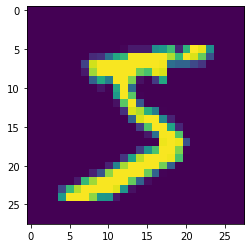

In [4]:
# Load MNIST Data set.
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(train_images.shape)
print(train_labels.shape)
print("train_images[0] shape: ",train_images[0].shape)
#show the first image.
plt.imshow(train_images[0])

In [5]:
def reshape_img(data):
  nsamples , nx , ny = data.shape
  return data.reshape(data.shape[0], nx, ny,1).astype('float32') / 255.0

In [6]:
train_img = reshape_img(train_images)
test_img = reshape_img(test_images)
print(train_img.shape)
train_img = (train_img - 127.5) / 127.5  # Normalize the images to [-1, 1]
train_data = tf.data.Dataset.from_tensor_slices(train_img.astype(np.float32))
train_data = train_data.shuffle(buffer_size=60000).batch(128,drop_remainder=True)

print(test_img.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [7]:
def get_generator_model(noise_shape):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(128, input_shape=noise_shape))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.7))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))

    model.add(tf.keras.layers.Dense(256, input_shape=noise_shape))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.7))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))

    model.add(tf.keras.layers.Dense(512, input_shape=noise_shape))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.7))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))

    model.add(tf.keras.layers.Dense(784, activation='tanh'))
    shape = (28,28,1)
    model.add(tf.keras.layers.Reshape(shape))

    #tf.keras.layers.Reshape()

    model.summary()

    noise = tf.keras.Input(shape=noise_shape)
    gen_image = model(noise)

    return tf.keras.Model(noise,gen_image)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1

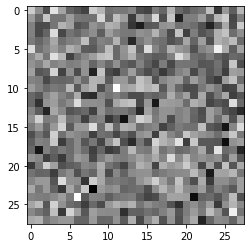

In [8]:
noise_shp = (100,)
generator = get_generator_model(noise_shp)
noise = tf.random.normal([1, 100])
generated_image = generator(noise,training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [9]:
def get_discriminator_model():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
  model.add(tf.keras.layers.Dense(128))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.3))

  model.add(tf.keras.layers.Dense(256))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.3))

  model.add(tf.keras.layers.Dense(512))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.3))

  model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # fake or real
  model.summary()

  img = tf.keras.Input(shape=(28,28,1))
  fake_or_real = model(img)

  return tf.keras.Model(img, fake_or_real)

In [10]:
discriminator = get_discriminator_model()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)              

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.001)

In [21]:
epochs = 300
batch_size = 128
noise_shape = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_shape])

In [22]:
def train_step():

  steps = 0
  for epoch in range(epochs):

    for img_batch in train_data:

      noise = tf.random.normal([batch_size, noise_shape])

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(img_batch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

      steps += 1

      if steps % 1000 == 0:
        fake_image = (generator(noise))
        plt.imshow(fake_image[0, :, :, 0], cmap='gray')
        plt.show()

        print("Epochs:{} , gen_loss:{} , disc_loss:{} , steps:{}".format(epoch,gen_loss,disc_loss,steps))    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


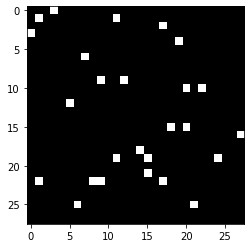

Epochs:2 , gen_loss:11.535212516784668 , disc_loss:2.1767098587588407e-05 , steps:1000


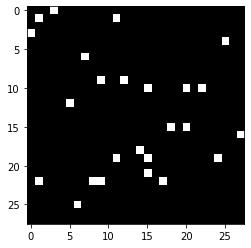

Epochs:4 , gen_loss:12.53342342376709 , disc_loss:8.388642527279444e-06 , steps:2000


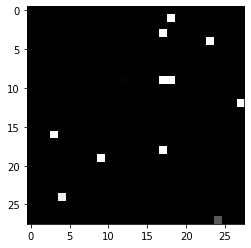

Epochs:6 , gen_loss:3.7407684326171875 , disc_loss:0.5317064523696899 , steps:3000


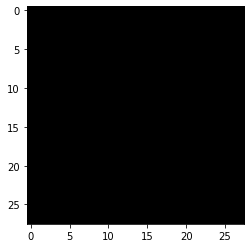

Epochs:8 , gen_loss:1.1179945468902588 , disc_loss:1.138164758682251 , steps:4000


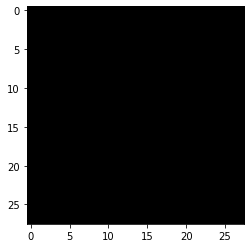

Epochs:10 , gen_loss:0.8169153332710266 , disc_loss:1.3640930652618408 , steps:5000


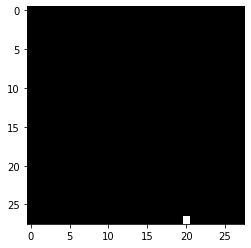

Epochs:12 , gen_loss:0.9527267217636108 , disc_loss:1.3499584197998047 , steps:6000


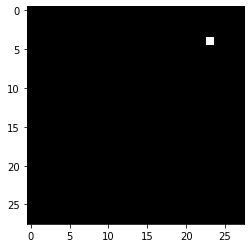

Epochs:14 , gen_loss:0.5417276620864868 , disc_loss:1.3541932106018066 , steps:7000


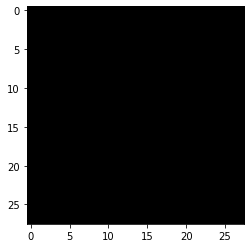

Epochs:17 , gen_loss:0.6370897889137268 , disc_loss:1.2428069114685059 , steps:8000


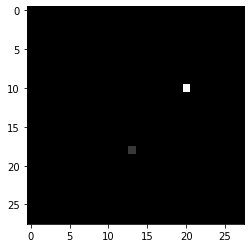

Epochs:19 , gen_loss:1.345618724822998 , disc_loss:1.386465072631836 , steps:9000


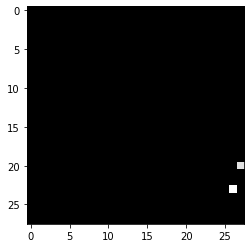

Epochs:21 , gen_loss:0.6262211203575134 , disc_loss:1.259152889251709 , steps:10000


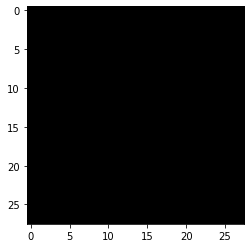

Epochs:23 , gen_loss:0.8955471515655518 , disc_loss:1.2211681604385376 , steps:11000


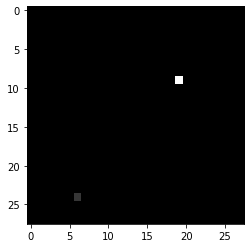

Epochs:25 , gen_loss:0.21908709406852722 , disc_loss:1.913002371788025 , steps:12000


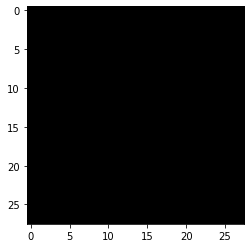

Epochs:27 , gen_loss:0.7122681140899658 , disc_loss:1.2652747631072998 , steps:13000


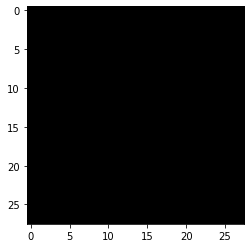

Epochs:29 , gen_loss:0.28094446659088135 , disc_loss:1.574872612953186 , steps:14000


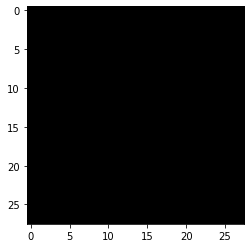

Epochs:32 , gen_loss:0.06941281259059906 , disc_loss:2.7313897609710693 , steps:15000


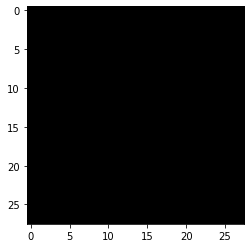

Epochs:34 , gen_loss:1.2763530015945435 , disc_loss:1.041094422340393 , steps:16000


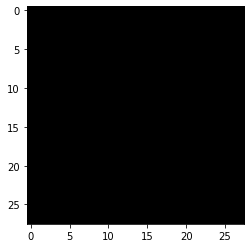

Epochs:36 , gen_loss:0.8997145891189575 , disc_loss:1.2599235773086548 , steps:17000


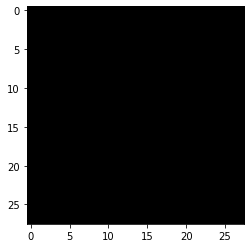

Epochs:38 , gen_loss:1.5595722198486328 , disc_loss:1.192919135093689 , steps:18000


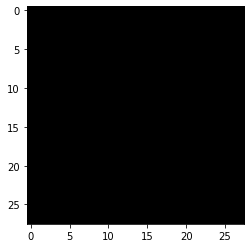

Epochs:40 , gen_loss:1.9726731777191162 , disc_loss:1.2658822536468506 , steps:19000


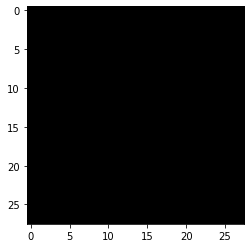

Epochs:42 , gen_loss:0.9817068576812744 , disc_loss:1.191239356994629 , steps:20000


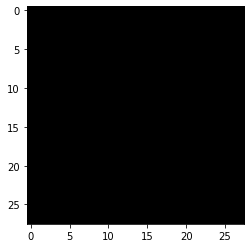

Epochs:44 , gen_loss:1.9558308124542236 , disc_loss:1.134037971496582 , steps:21000


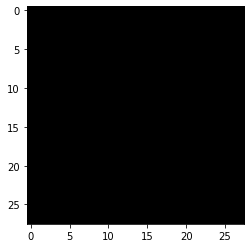

Epochs:47 , gen_loss:0.6531400680541992 , disc_loss:0.9268352389335632 , steps:22000


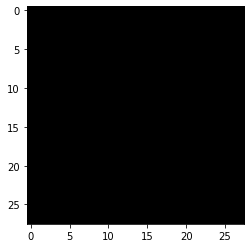

Epochs:49 , gen_loss:0.8181463479995728 , disc_loss:0.7638246417045593 , steps:23000


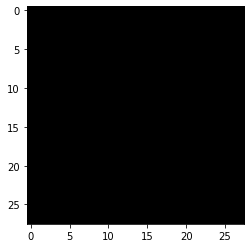

Epochs:51 , gen_loss:0.33982622623443604 , disc_loss:1.2988570928573608 , steps:24000


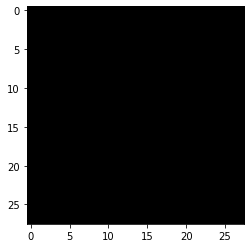

Epochs:53 , gen_loss:0.820888876914978 , disc_loss:0.7175642848014832 , steps:25000


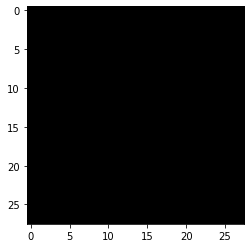

Epochs:55 , gen_loss:2.6068239212036133 , disc_loss:1.0328441858291626 , steps:26000


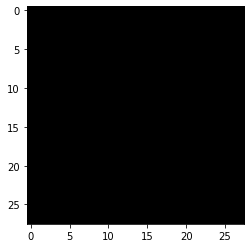

Epochs:57 , gen_loss:1.0770907402038574 , disc_loss:0.8807107210159302 , steps:27000


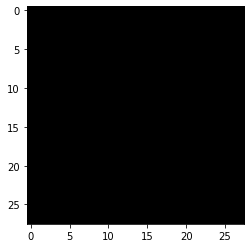

Epochs:59 , gen_loss:2.7105281352996826 , disc_loss:0.9708455204963684 , steps:28000


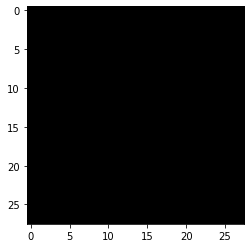

Epochs:61 , gen_loss:0.4053167998790741 , disc_loss:1.1439653635025024 , steps:29000


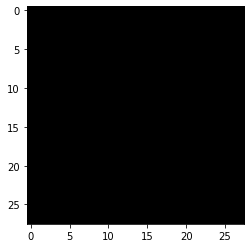

Epochs:64 , gen_loss:0.83002108335495 , disc_loss:0.6406694650650024 , steps:30000


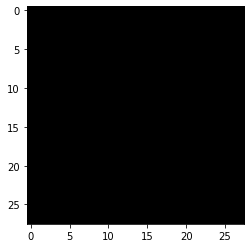

Epochs:66 , gen_loss:2.8907010555267334 , disc_loss:0.5163004994392395 , steps:31000


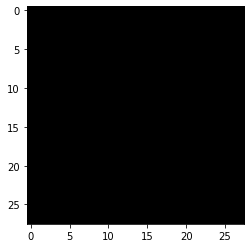

Epochs:68 , gen_loss:0.5734916925430298 , disc_loss:0.8661180734634399 , steps:32000


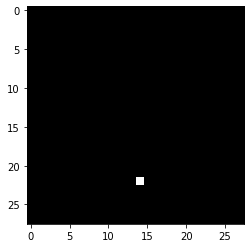

Epochs:70 , gen_loss:2.194178581237793 , disc_loss:1.155529499053955 , steps:33000


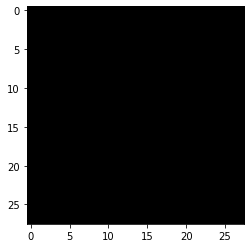

Epochs:72 , gen_loss:1.3150289058685303 , disc_loss:0.6677453517913818 , steps:34000


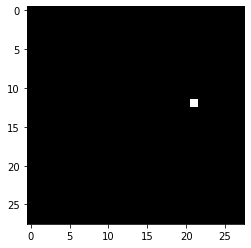

Epochs:74 , gen_loss:1.3594584465026855 , disc_loss:0.7015340924263 , steps:35000


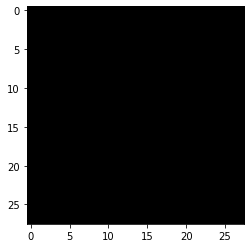

Epochs:76 , gen_loss:3.2735815048217773 , disc_loss:0.8038156032562256 , steps:36000


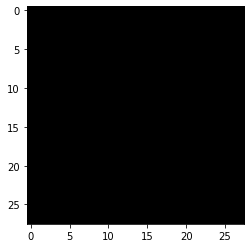

Epochs:79 , gen_loss:0.9898771047592163 , disc_loss:0.621709942817688 , steps:37000


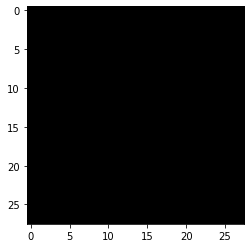

Epochs:81 , gen_loss:0.39565202593803406 , disc_loss:1.1436947584152222 , steps:38000


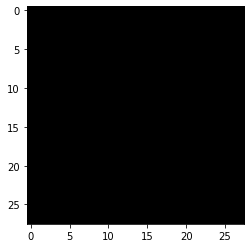

Epochs:83 , gen_loss:2.241450309753418 , disc_loss:0.32980334758758545 , steps:39000


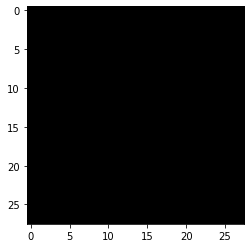

Epochs:85 , gen_loss:2.2569680213928223 , disc_loss:0.3355841338634491 , steps:40000


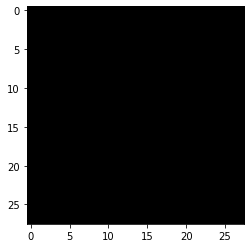

Epochs:87 , gen_loss:0.45485833287239075 , disc_loss:1.2329983711242676 , steps:41000


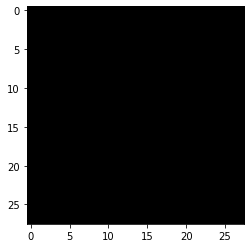

Epochs:89 , gen_loss:2.6256730556488037 , disc_loss:0.4867478609085083 , steps:42000


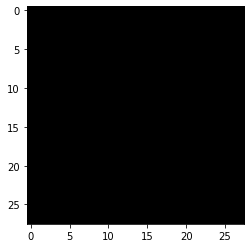

Epochs:91 , gen_loss:1.4001234769821167 , disc_loss:0.5258311033248901 , steps:43000


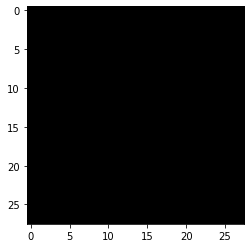

Epochs:94 , gen_loss:0.2959166169166565 , disc_loss:1.4291175603866577 , steps:44000


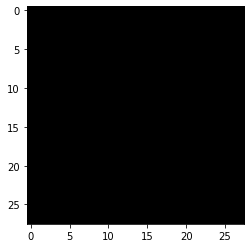

Epochs:96 , gen_loss:0.4505106806755066 , disc_loss:1.0700361728668213 , steps:45000


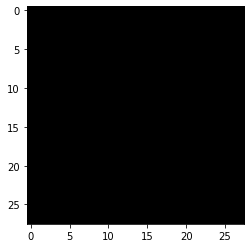

Epochs:98 , gen_loss:0.7239940166473389 , disc_loss:0.7828726768493652 , steps:46000


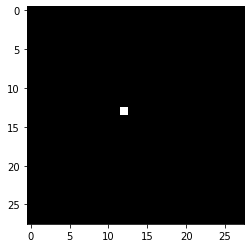

Epochs:100 , gen_loss:2.8955776691436768 , disc_loss:0.7452830076217651 , steps:47000


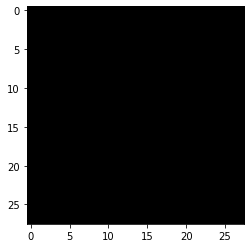

Epochs:102 , gen_loss:2.818695068359375 , disc_loss:0.695641279220581 , steps:48000


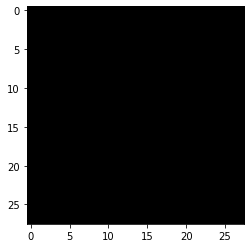

Epochs:104 , gen_loss:2.1177444458007812 , disc_loss:1.1261610984802246 , steps:49000


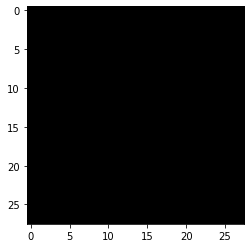

Epochs:106 , gen_loss:2.6068577766418457 , disc_loss:0.34653136134147644 , steps:50000


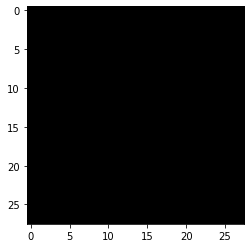

Epochs:108 , gen_loss:3.058292865753174 , disc_loss:0.4243759512901306 , steps:51000


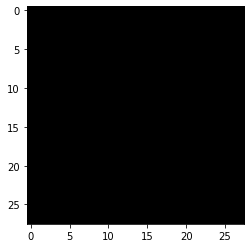

Epochs:111 , gen_loss:4.526137828826904 , disc_loss:0.8702149391174316 , steps:52000


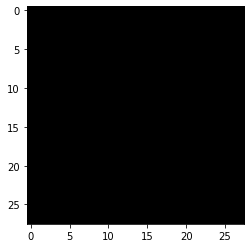

Epochs:113 , gen_loss:0.16456061601638794 , disc_loss:1.8899343013763428 , steps:53000


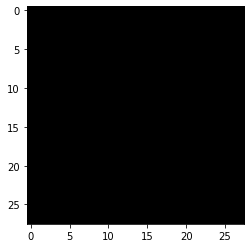

Epochs:115 , gen_loss:2.1501412391662598 , disc_loss:0.48069190979003906 , steps:54000


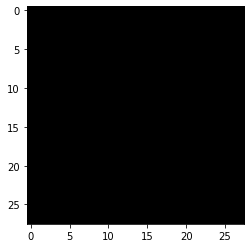

Epochs:117 , gen_loss:1.473381757736206 , disc_loss:0.482672780752182 , steps:55000


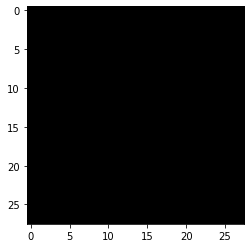

Epochs:119 , gen_loss:2.3593857288360596 , disc_loss:0.23797397315502167 , steps:56000


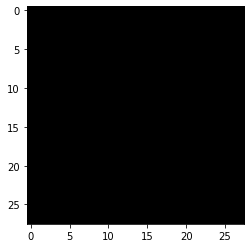

Epochs:121 , gen_loss:1.8260185718536377 , disc_loss:0.3128218352794647 , steps:57000


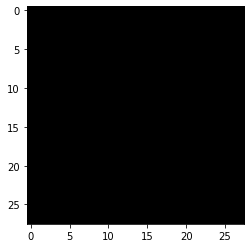

Epochs:123 , gen_loss:4.877232074737549 , disc_loss:0.7503735423088074 , steps:58000


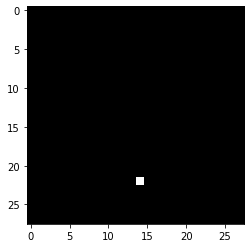

Epochs:126 , gen_loss:0.9301344156265259 , disc_loss:0.9603755474090576 , steps:59000


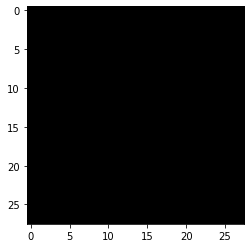

Epochs:128 , gen_loss:0.9396834373474121 , disc_loss:0.5398978590965271 , steps:60000


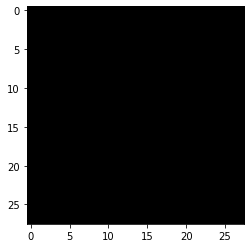

Epochs:130 , gen_loss:1.8774107694625854 , disc_loss:0.28317150473594666 , steps:61000


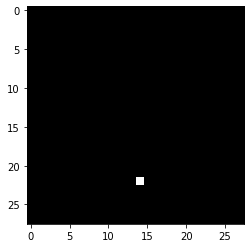

Epochs:132 , gen_loss:3.808181047439575 , disc_loss:0.299990713596344 , steps:62000


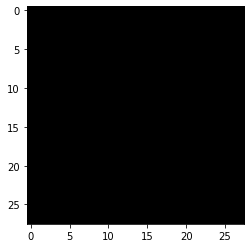

Epochs:134 , gen_loss:3.254816770553589 , disc_loss:0.5495558381080627 , steps:63000


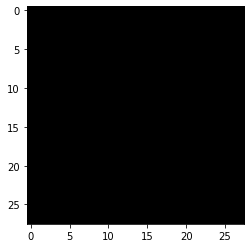

Epochs:136 , gen_loss:4.2881951332092285 , disc_loss:1.3398293256759644 , steps:64000


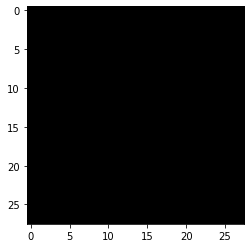

Epochs:138 , gen_loss:5.292446613311768 , disc_loss:1.7196687459945679 , steps:65000


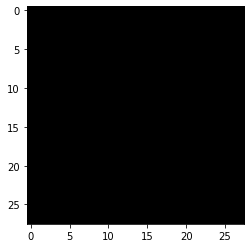

Epochs:141 , gen_loss:1.1775528192520142 , disc_loss:0.4535033702850342 , steps:66000


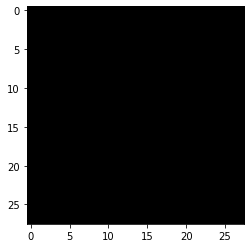

Epochs:143 , gen_loss:0.4007827043533325 , disc_loss:1.4214451313018799 , steps:67000


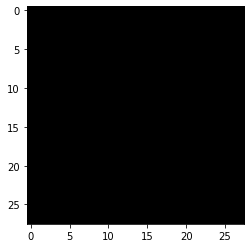

Epochs:145 , gen_loss:0.7881240248680115 , disc_loss:0.6428571343421936 , steps:68000


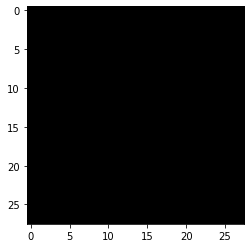

Epochs:147 , gen_loss:2.156371831893921 , disc_loss:0.23381981253623962 , steps:69000


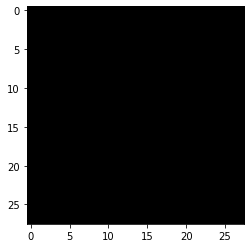

Epochs:149 , gen_loss:1.7697341442108154 , disc_loss:0.2639269530773163 , steps:70000


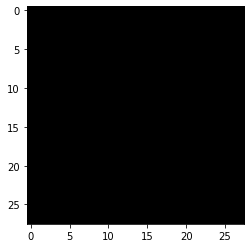

Epochs:151 , gen_loss:1.6381220817565918 , disc_loss:0.6551765203475952 , steps:71000


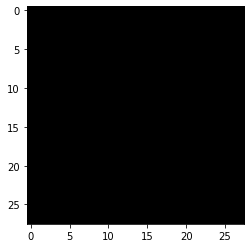

Epochs:153 , gen_loss:2.369903087615967 , disc_loss:0.44788265228271484 , steps:72000


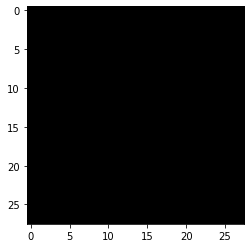

Epochs:155 , gen_loss:1.102625846862793 , disc_loss:0.4397772252559662 , steps:73000


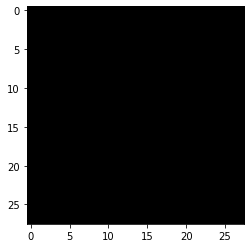

Epochs:158 , gen_loss:2.2652487754821777 , disc_loss:0.18029269576072693 , steps:74000


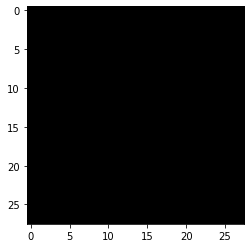

Epochs:160 , gen_loss:1.4625627994537354 , disc_loss:0.3055761754512787 , steps:75000


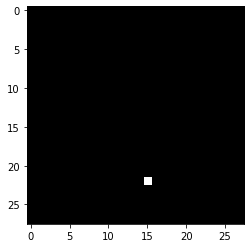

Epochs:162 , gen_loss:0.9932793378829956 , disc_loss:0.49908700585365295 , steps:76000


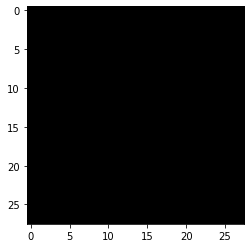

Epochs:164 , gen_loss:9.216547966003418 , disc_loss:3.361447334289551 , steps:77000


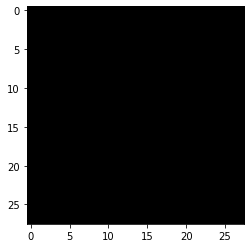

Epochs:166 , gen_loss:1.0685882568359375 , disc_loss:0.48068058490753174 , steps:78000


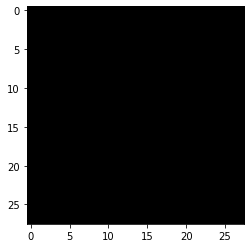

Epochs:168 , gen_loss:2.964228391647339 , disc_loss:0.28744009137153625 , steps:79000


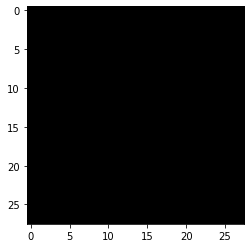

Epochs:170 , gen_loss:2.4836182594299316 , disc_loss:1.714678168296814 , steps:80000


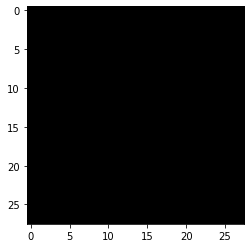

Epochs:173 , gen_loss:1.3904829025268555 , disc_loss:0.8495150208473206 , steps:81000


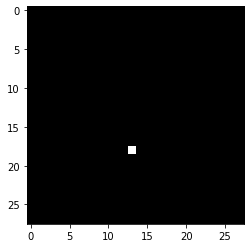

Epochs:175 , gen_loss:3.0081968307495117 , disc_loss:0.2541947662830353 , steps:82000


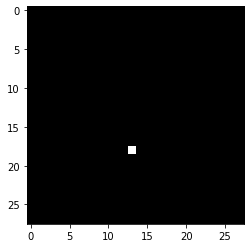

Epochs:177 , gen_loss:8.23726749420166 , disc_loss:0.0005481052212417126 , steps:83000


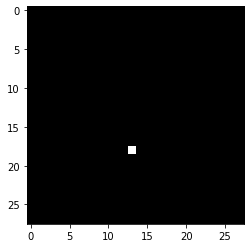

Epochs:179 , gen_loss:9.443697929382324 , disc_loss:0.00015512073878198862 , steps:84000


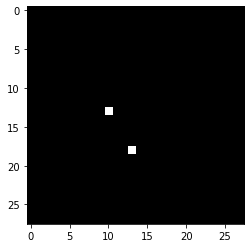

Epochs:181 , gen_loss:10.397239685058594 , disc_loss:6.921272142790258e-05 , steps:85000


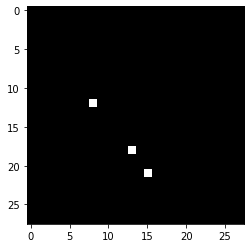

Epochs:183 , gen_loss:7.907839298248291 , disc_loss:0.0007788831135258079 , steps:86000


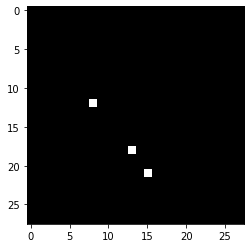

Epochs:185 , gen_loss:9.506821632385254 , disc_loss:0.00015920793521218002 , steps:87000


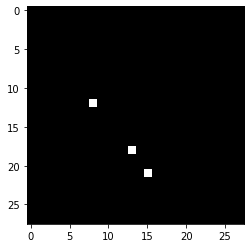

Epochs:188 , gen_loss:10.472697257995605 , disc_loss:6.161463534226641e-05 , steps:88000


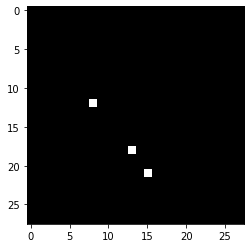

Epochs:190 , gen_loss:11.174816131591797 , disc_loss:3.0196253646863624e-05 , steps:89000


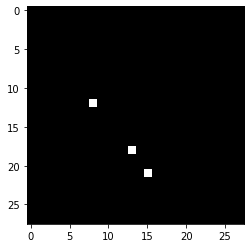

Epochs:192 , gen_loss:11.834755897521973 , disc_loss:1.5394904039567336e-05 , steps:90000


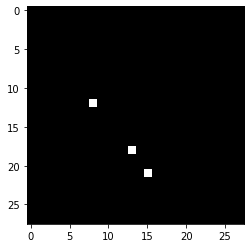

Epochs:194 , gen_loss:12.677397727966309 , disc_loss:7.068667400744744e-06 , steps:91000


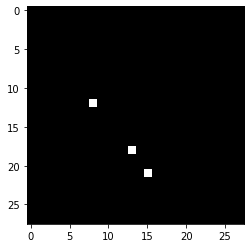

Epochs:196 , gen_loss:13.351396560668945 , disc_loss:3.5082393878838047e-06 , steps:92000


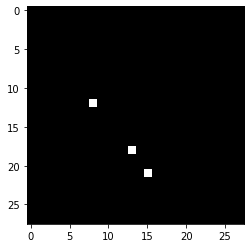

Epochs:198 , gen_loss:13.964295387268066 , disc_loss:1.9151930246152915e-06 , steps:93000


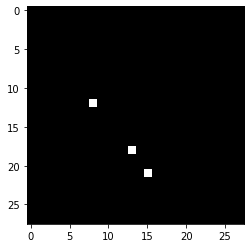

Epochs:200 , gen_loss:14.604647636413574 , disc_loss:1.0226583526673494e-06 , steps:94000


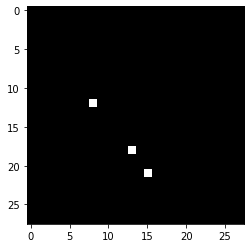

Epochs:202 , gen_loss:15.229145050048828 , disc_loss:5.506107072505984e-07 , steps:95000


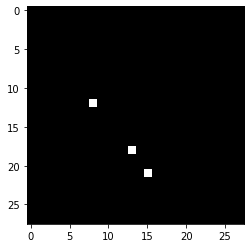

Epochs:205 , gen_loss:15.789262771606445 , disc_loss:3.093481382165919e-07 , steps:96000


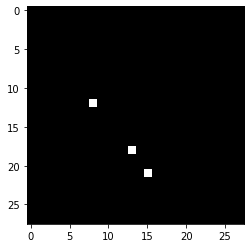

Epochs:207 , gen_loss:16.266902923583984 , disc_loss:1.8786855093821941e-07 , steps:97000


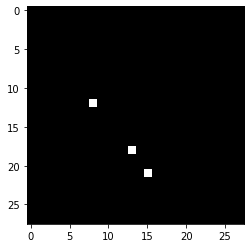

Epochs:209 , gen_loss:16.777549743652344 , disc_loss:1.152584019337155e-07 , steps:98000


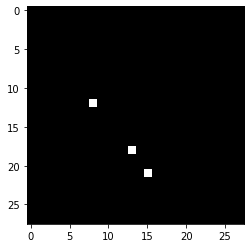

Epochs:211 , gen_loss:17.3084716796875 , disc_loss:6.663594831479713e-08 , steps:99000


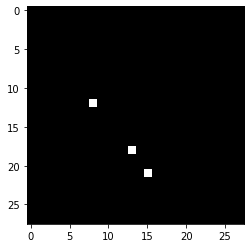

Epochs:213 , gen_loss:17.90064239501953 , disc_loss:3.745119414588771e-08 , steps:100000


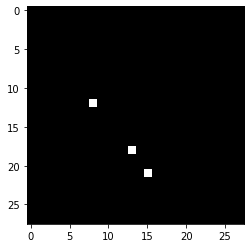

Epochs:215 , gen_loss:18.42558479309082 , disc_loss:2.1861357168972972e-08 , steps:101000


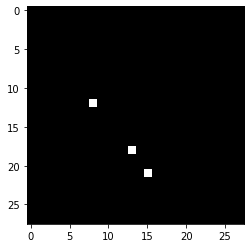

Epochs:217 , gen_loss:18.948068618774414 , disc_loss:1.3186088665406714e-08 , steps:102000


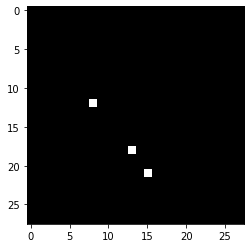

Epochs:220 , gen_loss:19.46957015991211 , disc_loss:7.800915469147185e-09 , steps:103000


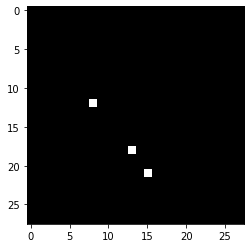

Epochs:222 , gen_loss:19.977771759033203 , disc_loss:4.664904906803713e-09 , steps:104000


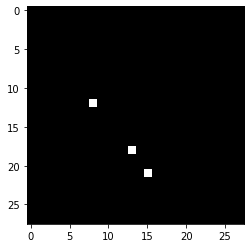

Epochs:224 , gen_loss:20.47676658630371 , disc_loss:2.8258195783337214e-09 , steps:105000


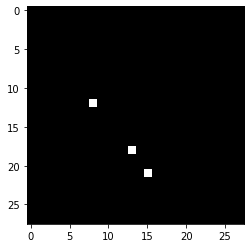

Epochs:226 , gen_loss:20.971895217895508 , disc_loss:1.7338231961261386e-09 , steps:106000


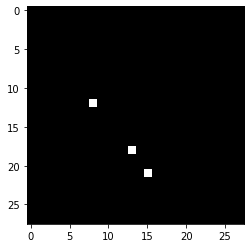

Epochs:228 , gen_loss:21.451828002929688 , disc_loss:1.0642315917408496e-09 , steps:107000


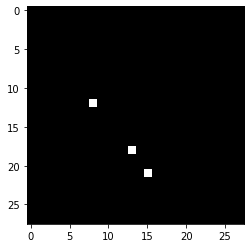

Epochs:230 , gen_loss:21.924701690673828 , disc_loss:6.76420752743212e-10 , steps:108000


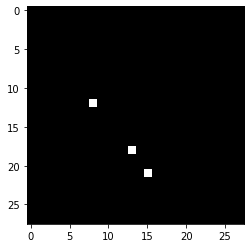

Epochs:232 , gen_loss:22.366910934448242 , disc_loss:4.319118951379153e-10 , steps:109000


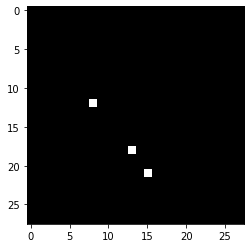

Epochs:235 , gen_loss:22.75124168395996 , disc_loss:2.891413497518869e-10 , steps:110000


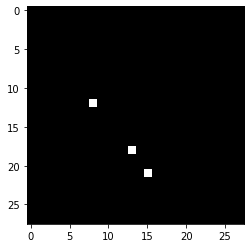

Epochs:237 , gen_loss:23.151748657226562 , disc_loss:1.9566370745849326e-10 , steps:111000


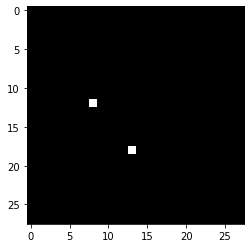

Epochs:239 , gen_loss:20.804712295532227 , disc_loss:1.8403227830532387e-09 , steps:112000


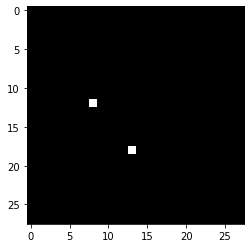

Epochs:241 , gen_loss:22.4597225189209 , disc_loss:3.5505001716451545e-10 , steps:113000


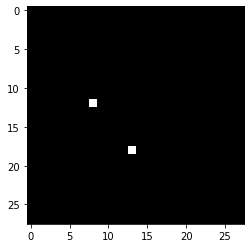

Epochs:243 , gen_loss:23.21941375732422 , disc_loss:1.6750319187242013e-10 , steps:114000


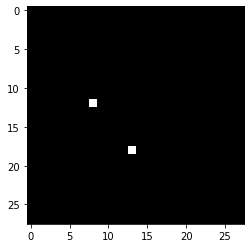

Epochs:245 , gen_loss:23.754907608032227 , disc_loss:9.837915204702341e-11 , steps:115000


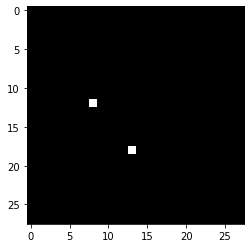

Epochs:247 , gen_loss:24.19257926940918 , disc_loss:6.349137882111222e-11 , steps:116000


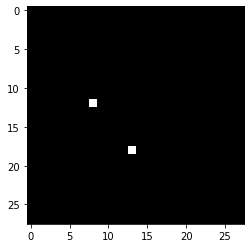

Epochs:249 , gen_loss:24.561044692993164 , disc_loss:4.409449194664461e-11 , steps:117000


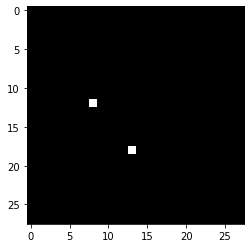

Epochs:252 , gen_loss:24.882442474365234 , disc_loss:3.158963715610419e-11 , steps:118000


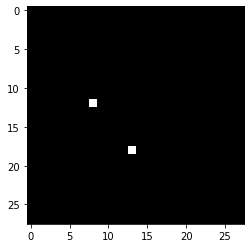

Epochs:254 , gen_loss:25.16017723083496 , disc_loss:2.4332418024908264e-11 , steps:119000


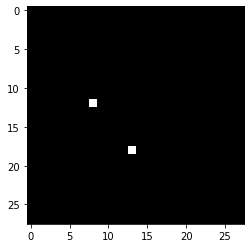

Epochs:256 , gen_loss:25.4039249420166 , disc_loss:1.870562732486647e-11 , steps:120000


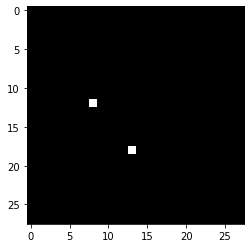

Epochs:258 , gen_loss:25.615217208862305 , disc_loss:1.5048230023184672e-11 , steps:121000


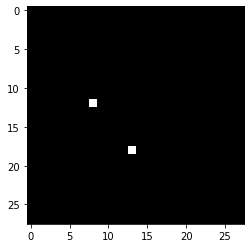

Epochs:260 , gen_loss:25.80104637145996 , disc_loss:1.2608870544883466e-11 , steps:122000


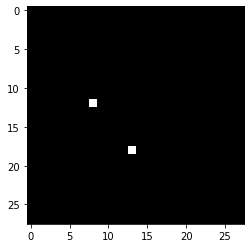

Epochs:262 , gen_loss:25.964088439941406 , disc_loss:1.0820113902076933e-11 , steps:123000


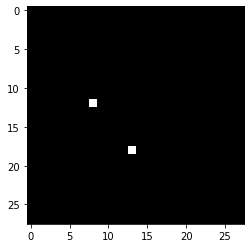

Epochs:264 , gen_loss:26.10801887512207 , disc_loss:9.43637008810061e-12 , steps:124000


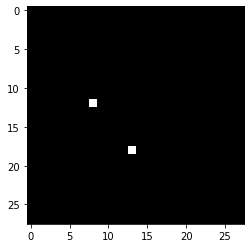

Epochs:267 , gen_loss:26.236677169799805 , disc_loss:8.286135666502048e-12 , steps:125000


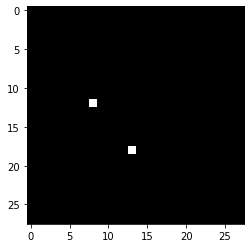

Epochs:269 , gen_loss:26.35259437561035 , disc_loss:7.279134760229677e-12 , steps:126000


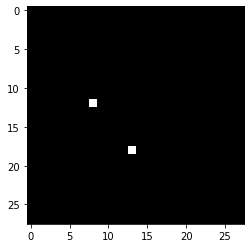

Epochs:271 , gen_loss:26.456567764282227 , disc_loss:6.54732084520715e-12 , steps:127000


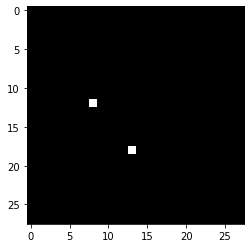

Epochs:273 , gen_loss:26.551158905029297 , disc_loss:5.9414166295179704e-12 , steps:128000


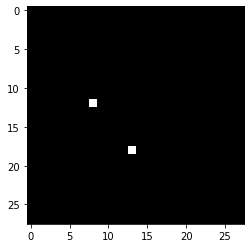

Epochs:275 , gen_loss:26.638269424438477 , disc_loss:5.491193437456854e-12 , steps:129000


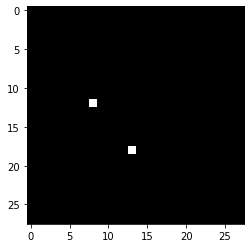

Epochs:277 , gen_loss:26.719072341918945 , disc_loss:4.995114565031766e-12 , steps:130000


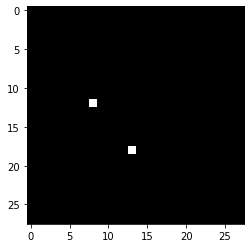

Epochs:279 , gen_loss:26.793302536010742 , disc_loss:4.673653391379373e-12 , steps:131000


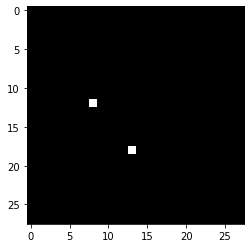

Epochs:282 , gen_loss:26.862550735473633 , disc_loss:4.382620134857351e-12 , steps:132000


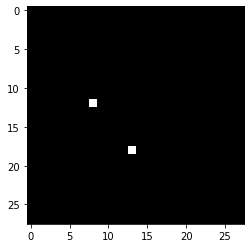

Epochs:284 , gen_loss:26.927532196044922 , disc_loss:4.0849840871048926e-12 , steps:133000


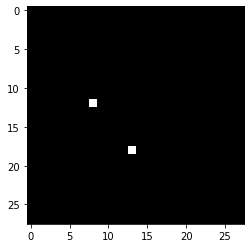

Epochs:286 , gen_loss:26.988338470458984 , disc_loss:3.7876767694511315e-12 , steps:134000


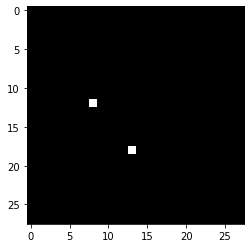

Epochs:288 , gen_loss:27.046010971069336 , disc_loss:3.5937190723256407e-12 , steps:135000


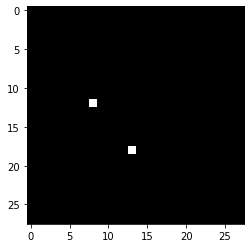

Epochs:290 , gen_loss:27.10016441345215 , disc_loss:3.471753917336229e-12 , steps:136000


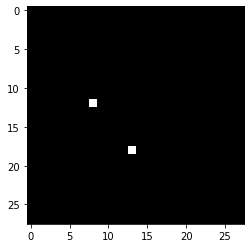

Epochs:292 , gen_loss:27.151514053344727 , disc_loss:3.27597801316748e-12 , steps:137000


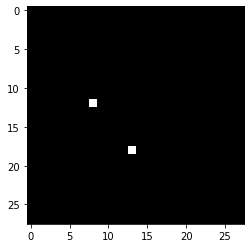

Epochs:294 , gen_loss:27.20086669921875 , disc_loss:3.1218673479660453e-12 , steps:138000


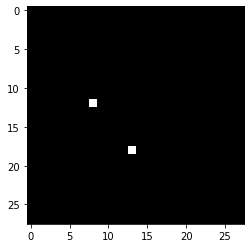

Epochs:297 , gen_loss:27.247760772705078 , disc_loss:2.9308994467514005e-12 , steps:139000


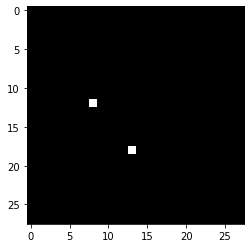

Epochs:299 , gen_loss:27.29241371154785 , disc_loss:2.8077861216613265e-12 , steps:140000


In [23]:
train_step()

In [ ]:
noise = tf.random.normal([1, 100])
fake_image = (generator(noise))
plt.imshow(fake_image[0, :, :, 0])
